# FVM modeling: introducing Newton (convective) boundary conditions in FiPy

Newton-type boundary conditions are not directly supported by FiPy, and even problematic if we try to implement them via Robin boundary conditions:

https://stackoverflow.com/questions/72644892/fipy-feasible-implementation-of-robin-boundary-conditions-on-a-1d-uniformgrid

Several approaches may be possible:

1. Use ghost cells that sit just to the left/right of the boundary cells and, at each time step, tune the differential between the ghost cell and the boundary cell to reflect Newton's law of cooling

2. Use Neumann boundary constraints and adapt them at each time step

3. Explicitly add/remove energy to the left and right boundary cells following Newton's law of cooling

The ghost cell approach **(1)** was tried, and gives qualitatively encouraging results, but has the fundamental problem that we cannot be sure that the energy flux finally applied by FiPy still follows Newton's law. The varying Neumann boundary **(2)** is not a preferred option, since too many unknowns about how FiPy handles this

Finally, explicit control of the energy in the system **(3)** via the boundary cells is preferred, since we are sure that the heat energy flux then follows Newton's law.

Remember that the temperature is a proxy for the internal energy/enthalpy of each cell, and by adapting the temperature of the left/right boundary cells we add/remove energy to the system.

In this notebook, we implement this "explicit flux control" (EFC) approach, which is robust and does not have too much of a problem with the delta pulse condition for the laser.

## Some definitions and equations

|   |   |  |
| -------- | ------------------------ | ---------|
| $T$      | temperature of the material | K        |
| $T_\textrm{ext}$ | exterior temperature  | K        |
| $k$      | thermal conductivity     | W/(m.K)  |
| $\rho$   | mass density             | kg/m3    |
| $c_p$    | specific heat capacity   | J/(kg.K) |
| $\alpha$ | thermal diffusivity      | m2/s     |
| $u$      | specific internal energy | J/kg     |
| $T_\textrm{ref}$ | zero-energy temperature  | K        |
| $U_i$    | internal energy of finite volume #$i$ | J |
| $h_N$    | Newtonian heat transfer coeffcient | W/(m2.K) |
| $A$      | heat transfer area / FV cell wall area  | m2      |
| $w$      | width of finite volume cell | m    |
| $V_\textrm{cell}$ | volume of finite volume cell | m3  |

The heat equation

$$ \frac{\partial T}{\partial t} = \frac{k}{\rho c_p} \nabla^2 T $$

We consider here that the material does not undergo any mechanical (pressure, volume) changes, and that the only mode of energy exchange is by means of heat transfer. Changes in internal energy are then the same as changes in enthalpy. Assuming a constant heat capacity, we arrive at the following expression for the (relative) specific energy (or enthalpy, c'est la même chose ici).

$$u(T) = c_p(T - T_\textrm{ref})$$


A finite-volume cell has internal energy

$$U_i = V_\textrm{cell} \rho c_v(T_i - T_\textrm{ref})$$

$$c_v \approx c_p$$

Changes in internal energy of the cell are directly proportional to changes in temperature

$$\Delta U_i = V_\textrm{cell} \rho c_p \Delta T_i$$

Instantaneous heat flux at the boundaries of the exterior FV cells.

$$\dot q = h_N(T - T_\textrm{ext})$$

The boundary cells undergoing heat flux, during a single time step $\Delta t$. (For now, we take the temperature at the exterior cell boundary to be identical to the temperature in the cell. FiPy does also give the temperature at the boundaries; we may use that later).

For cell #0 (left cell)

$$\Delta U_0 = \Delta Q_0 = A h_N(T_i - T_\textrm{ext})$$

This internal energy change due to convective Newtonian heat flux at the boundary is tantamount to a temperature change:

$$\Delta T_0 = \frac{\Delta U_0}{V_\textrm{cell} \rho c_p}
= \frac{A h_N}{V_\textrm{cell} \rho c_p}(T_i - T_\textrm{ext})$$

or even better ($V_\textrm{cell} = A w$)

$$\Delta T_0 = \frac{h_N}{w \rho c_p}(T_i - T_\textrm{ext})$$

Therefore, in order to model the heat flux at the boundaries, and the energy loss (or gain) associated to it, we should at each time step change the temperature of the boundary cell (here, cell #0) by $\Delta T_0$


## Units

We still need to get all units right, and the parameters compatible with SI and physical material properties. The sum over all cells should really correspond to the total thermal energy in the system.

## FiPy model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from fipy import Grid1D, CellVariable
from fipy import TransientTerm, DiffusionTerm

In [3]:
L = 10.
Nx = 200
dx = L/Nx
Ti = 0.
Tx = 100.
Text = 0.
hcp = 1.0
alpha = 1.0
# hcp = 0.0 # test with Newton = 0! This gives indeed the same result as standard "no-flux" boundaries

In [4]:
msh = Grid1D(nx=Nx, dx=dx)

In [5]:
xco, = msh.cellCenters

In [6]:
T = CellVariable(mesh = msh, name = 'T')

In [7]:
Tprofile = T.value

In [8]:
T[0] = Tx
T[1:] = Ti

In [9]:
eqn = TransientTerm(var=T) == DiffusionTerm(coeff=alpha, var=T)

In [10]:
t = 0
deltat = 0.04
Nsteps = 2000

In [11]:
Ttotal = np.zeros(Nsteps)
Tright = np.zeros(Nsteps)
Tleft = np.zeros(Nsteps)
tt = np.arange(Nsteps) * deltat

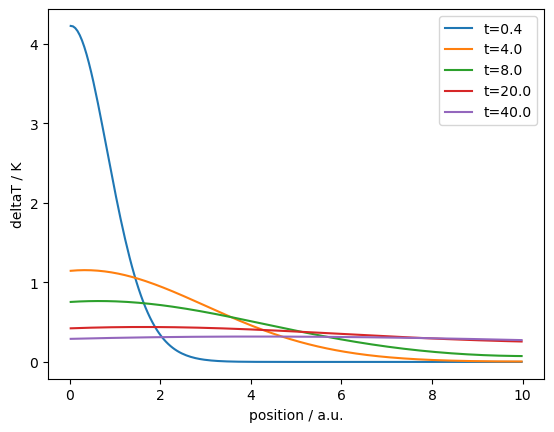

In [12]:
displist = [10, 100, 200, 500, 1000]
for i in range(2000):
    
    # analyze and plot selected profiles
    Ttotal[i] = Tprofile.sum() # total energy by summing all cells (temperature proportional to cell energy content)
    Tright[i] = Tprofile[-1]
    Tleft[i] = Tprofile[0]
    if i in displist:
        plt.plot(xco, Tprofile, label = 't={0:.1f}'.format(t))

    # add/remove energy to left and right cells, following newton condition
    # TODO: find the correct expression to calculate `hcp`
    deltaTleft = hcp * (Text-Tprofile[0]) * deltat
    Tprofile[0] = Tprofile[0] + deltaTleft
    deltaTright = hcp * (Text-Tprofile[-1]) * deltat
    Tprofile[-1] = Tprofile[-1] + deltaTright
    
    # solve time step
    eqn.solve(dt = deltat); t+=deltat

plt.xlabel('position / a.u.')
plt.ylabel('deltaT / K')
plt.legend()

Text(0, 0.5, 'deltaT(left side) / K')

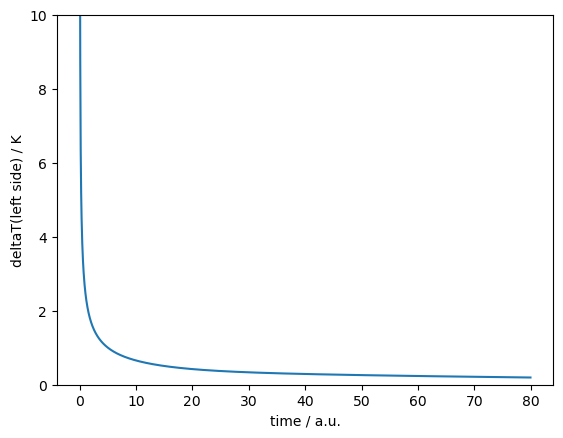

In [13]:
plt.plot(tt,Tleft)
plt.ylim(0,10)
plt.xlabel('time / a.u.')
plt.ylabel('deltaT(left side) / K')

Text(0, 0.5, 'deltaT(right side) / K')

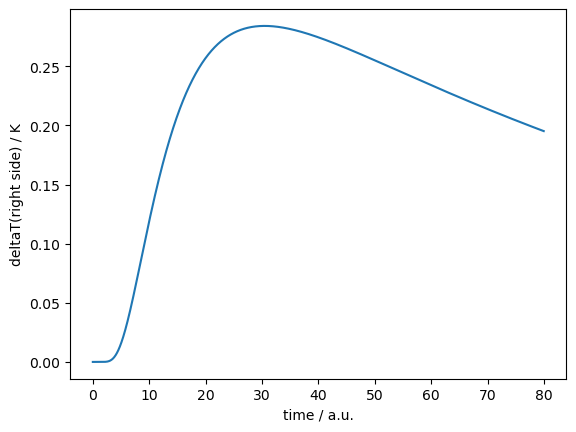

In [14]:
plt.plot(tt,Tright)
plt.xlabel('time / a.u.')
plt.ylabel('deltaT(right side) / K')

## To do!

We have introduced a compound variable `hcp` that is some combination of the Newton coefficient, specific heat capacity etc. You will have to find the correct expression based on the relevant physical quantities.